[ pytorch Yellow Taxi 모델 ]

- 데이터셋 : taxis.csv
- 학습방법 : 지도학습 + 회귀 

< 모듈 및 파일 로딩 > <hr>

In [2]:
# [1-1] 모듈 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim      # 최적화 모듈 

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader        ## 학습 데이터셋 관련 모듈
import torchmetrics.functional as mt
from torchmetrics.regression import *  # 회귀

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler  # 스케일링 모듈
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder # 인코딩 모듈 

In [3]:
# [1-2] 파일로딩
data_file = 'taxis.csv'

taxi_df = pd.read_csv(data_file, skipfooter=1, engine='python')

In [4]:
display(taxi_df.head(2))

pickup              dropoff  passengers  distance  fare   tip  \
0  2019-03-23 20:21:09  2019-03-23 20:27:24           1      1.60   7.0  2.15   
1  2019-03-04 16:11:55  2019-03-04 16:19:00           1      0.79   5.0  0.00   

   tolls  total   color      payment            pickup_zone  \
0    0.0  12.95  yellow  credit card        Lenox Hill West   
1    0.0   9.30  yellow         cash  Upper West Side South   

            dropoff_zone pickup_borough dropoff_borough  
0    UN/Turtle Bay South      Manhattan       Manhattan  
1  Upper West Side South      Manhattan       Manhattan

In [5]:
# 용어 정리
# pickup : 승차  
# dropoff : 하차
# passengers : 승객 수
# distance : 거리
# fare : 요금
# tip : 팁
# tolls : 통행료
# total : 총액
# color : 차량 색상
# payment : 결제 방식
# borough : 지역

In [6]:
# 시간 특성 추출 : 새로운 피쳐 생성
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup'])
taxi_df['dropoff_datetime'] = pd.to_datetime(taxi_df['dropoff'])
taxi_df['trip_duration'] = (taxi_df['dropoff_datetime'] - taxi_df['pickup_datetime']).dt.total_seconds() / 60
taxi_df['pickup_hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['pickup_dayofweek'] = taxi_df['pickup_datetime'].dt.dayofweek
taxi_df['pickup_month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['pickup_weekend'] = taxi_df['pickup_dayofweek'].isin([5, 6]).astype(int)


In [7]:
# [1-3] 데이터 확인 
taxi_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6432 entries, 0 to 6431
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup            6432 non-null   object        
 1   dropoff           6432 non-null   object        
 2   passengers        6432 non-null   int64         
 3   distance          6432 non-null   float64       
 4   fare              6432 non-null   float64       
 5   tip               6432 non-null   float64       
 6   tolls             6432 non-null   float64       
 7   total             6432 non-null   float64       
 8   color             6432 non-null   object        
 9   payment           6388 non-null   object        
 10  pickup_zone       6406 non-null   object        
 11  dropoff_zone      6387 non-null   object        
 12  pickup_borough    6406 non-null   object        
 13  dropoff_borough   6387 non-null   object        
 14  pickup_datetime   6432 n

In [8]:
# [1-4] 결측치 확인
taxi_df.fillna({
    'pickup_zone': 'unknown', 
    'dropoff_zone': 'unknown',
    'pickup_borough': 'unknown', 
    'dropoff_borough': 'unknown',
    'payment': 'unknown',
    'color': 'unknown'
}, inplace=True)

taxi_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6432 entries, 0 to 6431
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   pickup            6432 non-null   object        
 1   dropoff           6432 non-null   object        
 2   passengers        6432 non-null   int64         
 3   distance          6432 non-null   float64       
 4   fare              6432 non-null   float64       
 5   tip               6432 non-null   float64       
 6   tolls             6432 non-null   float64       
 7   total             6432 non-null   float64       
 8   color             6432 non-null   object        
 9   payment           6432 non-null   object        
 10  pickup_zone       6432 non-null   object        
 11  dropoff_zone      6432 non-null   object        
 12  pickup_borough    6432 non-null   object        
 13  dropoff_borough   6432 non-null   object        
 14  pickup_datetime   6432 n

In [9]:
print(taxi_df['pickup_hour'])

0       20
1       16
2       17
3        1
4       13
        ..
6427    18
6428     9
6429    17
6430    22
6431    10
Name: pickup_hour, Length: 6432, dtype: int32


< 데이터셋 준비 > <hr>

In [10]:
# [2-1] 피쳐 타겟 분리
featureDF = pd.concat([taxi_df[taxi_df.columns[16:]], taxi_df[[taxi_df.columns[4], taxi_df.columns[6]]]], axis=1)
TargetSR = taxi_df[taxi_df.columns[4]]

print(featureDF.shape)
print(TargetSR.shape)

(6432, 7)
(6432,)


In [11]:
# [2-2] 피쳐 전처리 : 데이터 타입 확인, 값의 범위 맞추기

# 데이터 타입 변경 int64 -> int32
featureDF['pickup_weekend'] = featureDF['pickup_weekend'].astype('int32')
print(featureDF.dtypes)

trip_duration       float64
pickup_hour           int32
pickup_dayofweek      int32
pickup_month          int32
pickup_weekend        int32
fare                float64
tolls               float64
dtype: object


In [12]:
# [2-3] train test 데이터셋 분리
x_train, x_test, y_train, y_test = train_test_split(featureDF, 
                                                    TargetSR,
                                                    test_size=0.2,
                                                    random_state=42)
                                    

In [13]:
# [2-4] 스케일링 

# 스케일링할 열만 선택
columns_to_scale = ['trip_duration', 'fare', 'tolls']

# 스케일러 초기화 및 fit
scaler = StandardScaler()
scaler.fit(x_train[columns_to_scale])

# 스케일링된 열을 transform
train_scaled = scaler.transform(x_train[columns_to_scale])
test_scaled = scaler.transform(x_test[columns_to_scale])

# 스케일링되지 않은 열 유지
train_other_cols = x_train.drop(columns=columns_to_scale)
test_other_cols = x_test.drop(columns=columns_to_scale)

# 스케일링된 열을 데이터프레임으로 변환
train_scaled_df = pd.DataFrame(train_scaled, columns=columns_to_scale, index=x_train.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=columns_to_scale, index=x_test.index)

In [14]:
# [3-5] 인코딩 
from sklearn.preprocessing import OneHotEncoder
hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# 인코딩할 범주형 피쳐 선택
categorical_features = ['pickup_hour', 'pickup_dayofweek', 'pickup_month', 'pickup_weekend']

# 범주형 데이터를 OneHotEncoding 실행
encoded_categorical = hot.fit(x_train[categorical_features])

# 범주형 열 transform 및 데이터프레임 변환
train_encoded = hot.transform(x_train[categorical_features])
test_encoded = hot.transform(x_test[categorical_features])

# 인코딩된 열을 데이터프레임으로 변환
encoded_columns = hot.get_feature_names_out(categorical_features)
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_columns, index=x_train.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_columns, index=x_test.index)

In [15]:
# 스케일링한 열과 인코딩한 열 병합
x_train = pd.concat([train_scaled_df, train_encoded_df], axis=1)
x_test = pd.concat([test_scaled_df, test_encoded_df], axis=1)

In [16]:
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [17]:
# shape 확인
print(x_train.shape)
print(y_train.shape)

(5145, 38)
(5145,)


< 커스텀 데이터셋 클래스 설계 및 구현 > <hr>

In [18]:
# [4-1] 전용 데이터셋 클래스 
class TaxiDataset(Dataset):
    # 피쳐와 타겟 분리 및 전처리 진행 
    def __init__(self, featureDF, targetSR):
        super().__init__()
        self.feature = featureDF
        self.target  = targetSR
        self.rows = featureDF.shape[0]
        self.cols = featureDF.shape[1]
    
    # 데이터셋의 샘플 수 반환 메서드 
    def __len__(self):
        return self.rows 

    # DataLoader에서 batch_size만큼 호출하는 메서드
    # 인덱스에 해당하는 피쳐와 타겟 반환 단, Tensor 형태
    def __getitem__(self, index):
       arrFeature = self.feature.iloc[index].values   # ndarray (1차원)
       arrTarget = self.target[index].reshape(-1)     # ndarray (1차원)
   
       return torch.FloatTensor(arrFeature), torch.LongTensor(arrTarget)

In [19]:
Taxi_DS = TaxiDataset(x_train,y_train)
len(Taxi_DS)

5145

In [20]:
# [4-2] 확인 
# Train용 DataSet 필수 
# Test용 Dataset 선택  => 데이터가 많다면 DS, DL 생성 사용
#                     => 데이터가 많지 않다면 DS, DL 생성 필요 X 
trainDS = TaxiDataset(x_train, y_train)
testDS  = TaxiDataset(x_test, y_test)
print(trainDS[1])
print(testDS[2])

(tensor([-1.0181, -0.7881, -0.2283,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000]), tensor([4]))
(tensor([-0.5162, -0.3997, -0.2283,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000]), tensor([8]))


In [21]:
# [4-3] Train용 데이터로더
trainDL = DataLoader(dataset=trainDS, batch_size=3)
for feature, label in trainDL:
    print(feature, label)
    break

tensor([[ 0.9302,  0.5929, -0.2283,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000],
        [-1.0181, -0.7881, -0.2283,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000],
        [-0.5317, -0.5292, -0.2283,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,

In [22]:
# [4-4] Test용 데이터로더
testDL = DataLoader(dataset=testDS, batch_size=3)
for feature, label in testDL:
    print(feature, label, sep='\n')
    break

tensor([[-0.2963, -0.4429, -0.2283,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000],
        [-0.2032, -0.2702, -0.2283,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [-0.5162, -0.3997, -0.2283,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,

< 모델 설계 및 클래스 구현 > <hr>

In [23]:
# [5-1] 모델 클래스 설계 
## - 클래스 이 름 : Multi_Model
## - 부 모 클래스 : nn.Module
## - 데 이  터 셋 : 피쳐 38(원래 7) , 타겟 1 , 타겟 수치형
## - 학습    방법 : 지도학습 - 분류(다중)
## - 구현알고리즘 : 인공신경망계열 DNN 
## -------------------------------------------------
##             입력       출력/퍼셉트론수    활성화함수
## - 입력층      38(피쳐)   1280               ReLU
## - 은닉층      1280      640                ReLU
## - 은닉층      640       320                ReLU
## - 출력층      320       1  (타겟)           -
## 피쳐와 타겟을 제외하고 나머지는 사용자 지정 : 단, 초반에 퍼셉트론 수가 많은 것은 GOOD

In [24]:
# 클래스 생성
class Multi_Model(nn.Module):
    
    def __init__(self, in_in, in_out, h1_out, h2_out, out_out):
        super().__init__()
        
        
        self.input_layer = nn.Linear(in_in, in_out)
        self.hidden_layer1 = nn.Linear(in_out, h1_out)
        self.hidden_layer2 = nn.Linear(h1_out, h2_out)
        self.output_layer = nn.Linear(h2_out, out_out)
        
    
    # 순방향 학습 진행 메서드 : forward로 무조건 고정!!
    # forward : 필수 오버라이딩 메서드 
    # 매개변수 data : 학습용 데이터 전달
    
    # 입력층 학습 
    def forward(self,data):     
        output = self.input_layer(data)
        output = F.relu(output)
        
        output = self.hidden_layer1(output)
        output = F.relu(output)
        
        output = self.hidden_layer2(output)
        output = F.relu(output)
        
        output = self.output_layer(output)
    
        return output
        

In [25]:
# [5-2] 모델 구조 확인
model = Multi_Model(38,1280,640,320,1)

print(model)

Multi_Model(
  (input_layer): Linear(in_features=38, out_features=1280, bias=True)
  (hidden_layer1): Linear(in_features=1280, out_features=640, bias=True)
  (hidden_layer2): Linear(in_features=640, out_features=320, bias=True)
  (output_layer): Linear(in_features=320, out_features=1, bias=True)
)


< 학습 준비 > <hr>

In [26]:
# [6-1] 학습 관련 설정들
EPOCHS = 50               # 학습용 DS를 처음부터 끝까지 50번 학습
BATCH_SIZE = 128          # DS를 학습량 만큼 나눈 사이즈
ITERATION = int(x_train.shape[0]/BATCH_SIZE)             # 학습용 DS가 분리된 수 => 1 에포크에 W,b 업데이트 횟수 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  # 학습, 데이터셋 로딩 등 GPU에서 실행 여부 설정  

print(f'EPOCHS : {EPOCHS}')
print(f'BATCH_SIZE : {BATCH_SIZE}')
print(f'ITERATION : {ITERATION}')
print(f'DEVICE : {DEVICE}')

EPOCHS : 50
BATCH_SIZE : 128
ITERATION : 40
DEVICE : cpu


In [27]:
# [6-2] 학습 관련 인스턴스들 
LR = 0.01                                           # 학습률 (0.01)
MODEL = Multi_Model(38,1280,640,320,1)              # 학습 모델
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LR)   # 최적화, 즉 경사하강법 알고리즘으로 W,b의 값 갱신 
LOSS_FN = nn.MSELoss()                    

TRAINDL = DataLoader(trainDS, batch_size=BATCH_SIZE)
TESTDL = DataLoader(testDS,  batch_size=BATCH_SIZE)

In [28]:
# [6-3] 검증 함수
# - 검증용 데이터셋으로 모델 검증
# - 학습 지속여부 결정 기준이 됨

def evaluate():
    # 모델을 검증 모드로 설정
    MODEL.eval()
    
    # W, b 업데이트 방지
    with torch.no_grad():
        T_RMSE, T_R2, CNT = 0, 0, 0
        for feature, target in TESTDL:
            # 예측 수행
            pre_y = MODEL(feature)
            
            # 손실 계산
            mse_loss = nn.MSELoss()  # PyTorch MSE 사용
            mse = mse_loss(pre_y, target.float())
            
            # RMSE 계산
            rmse = torch.sqrt(mse)
            
            # 정확도 계산 (R2Score 확인 필요)
            r2 = R2Score()
            r_2 = r2(pre_y, target.float())
            
            # 결과 누적
            T_RMSE += rmse.item()  # Loss 누적
            T_R2 += r_2.item()    # 정확도 누적
            CNT += 1
        
        # 최종 평균 반환
        return T_RMSE / CNT, T_R2 / CNT


In [29]:
# [6-4] 학습 함수
def training():
    # 학습 모드 설정
    MODEL.train()

    # 손실 함수 및 정확도 계산 객체 생성 (루프 밖에서 한 번만 생성)
    mse_loss = nn.MSELoss()  # PyTorch 표준 MSE 손실 함수 사용
    r2_score = R2Score()    # R2 정확도 계산 클래스 사용

    E_RMSE, E_R2 = 0, 0
    CNT = 0  # 반복 횟수 카운트

    for feature, target in TRAINDL:
        # 가중치 기울기 0 초기화
        OPTIMIZER.zero_grad()

        # 학습 진행
        pre_y = MODEL(feature)

        # 손실 계산
        mse = LOSS_FN(pre_y, target.float())  # target.float() 사용
        rmse = torch.sqrt(mse)  # RMSE 계산

        # 정확도 계산
        r2 = r2_score(pre_y, target.float())  # target.float() 사용

        # 역전파 진행 (MSE 사용)
        mse.backward()

        # 가중치/절편 업데이트
        OPTIMIZER.step()

        # 결과 누적
        E_RMSE += rmse.item()
        E_R2 += r2.item()
        CNT += 1

    # 반복 횟수 기반 평균 계산
    return E_RMSE / CNT, E_R2 / CNT


In [30]:
# [6-5] 학습 / 검증 동시 진행 

# 에포크 : DS 처음부터 ~ 끝까지 학습
HIST = {'Train':[], 'Valid':[]}   

# 에포크 단위 학습/검증 진행 
for epoch in range(EPOCHS):
    trainLoss, trainacc = training()
    validLoss, validacc = evaluate()

    HIST['Train'].append((trainLoss,trainacc))
    HIST['Valid'].append((validLoss,validacc))

    print(f'\nEPOCH[{epoch+1}/{EPOCHS}]----------------')
    print(f'- TRAIN_LOSS {trainLoss:.5f}')
    print(f'- VALID_LOSS {validLoss:.5f}')
    print('-------------------------------')
    print(f'- TRAIN_R2SCORE {trainacc:.5f}')
    print(f'- VALID_R2SCORE {validacc:.5f}')


EPOCH[1/50]----------------
- TRAIN_LOSS 5.44033
- VALID_LOSS 2.65141
-------------------------------
- TRAIN_R2SCORE 0.62478
- VALID_R2SCORE 0.94454

EPOCH[2/50]----------------
- TRAIN_LOSS 1.40754
- VALID_LOSS 0.79058
-------------------------------
- TRAIN_R2SCORE 0.98285
- VALID_R2SCORE 0.99505

EPOCH[3/50]----------------
- TRAIN_LOSS 0.64178
- VALID_LOSS 0.59646
-------------------------------
- TRAIN_R2SCORE 0.99651
- VALID_R2SCORE 0.99716

EPOCH[4/50]----------------
- TRAIN_LOSS 0.49528
- VALID_LOSS 0.45569
-------------------------------
- TRAIN_R2SCORE 0.99783
- VALID_R2SCORE 0.99832

EPOCH[5/50]----------------
- TRAIN_LOSS 0.41850
- VALID_LOSS 0.39865
-------------------------------
- TRAIN_R2SCORE 0.99841
- VALID_R2SCORE 0.99871

EPOCH[6/50]----------------
- TRAIN_LOSS 0.33915
- VALID_LOSS 0.36729
-------------------------------
- TRAIN_R2SCORE 0.99897
- VALID_R2SCORE 0.99891

EPOCH[7/50]----------------
- TRAIN_LOSS 0.31382
- VALID_LOSS 0.33699
-----------------------

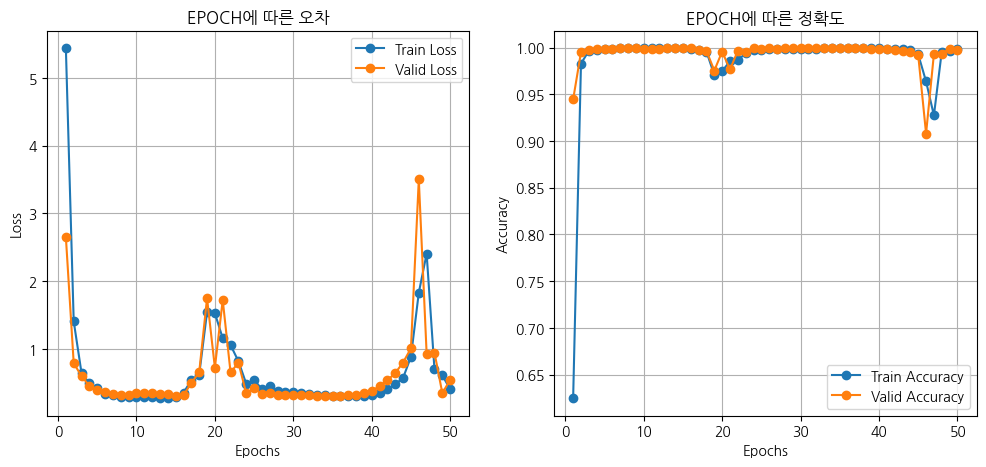

In [31]:
# [6-6] 시각화 
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 에포크 수 설정
epochs = len(HIST['Train'])

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), [x[0] for x in HIST['Train']], label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), [x[0] for x in HIST['Valid']], label='Valid Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EPOCH에 따른 오차')
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), [x[1] for x in HIST['Train']], label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), [x[1] for x in HIST['Valid']], label='Valid Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EPOCH에 따른 정확도')
plt.legend()
plt.grid(True)

plt.show()